In [5]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import tensorflow as tf
import time
from skimage import io
from skimage.transform import resize
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential, Model
from napari.layers import Image, Labels
from csbdeep.utils import normalize
from magicgui import magicgui
import napari

# Ilastik-like pixel classifier
### An interactive pixel classifier that uses kernels extracted from a CNN (VGG16 trained on imagenet) instead of traditional filter banks as feature extractors.
<img src="filter_set.png" width="700"/>

See end of notebook for an in-depth description of the classifier.

### Load the helper functions.. (nothing to do here)

In [89]:
@magicgui(call_button='train classifier')
def clf_widget():
    '''GUI widget to train the classifier.
       Trains the classifier based on the annotations made,
       and predicts the class for all pixels in the rest of the image.
    '''
    #extract the labels
    annotations = np.array(labels_layer.data)
    X,y = annotations_to_tensor(features,annotations)
    clf.fit(X, y) #train the classifier on the new labels
    
    #now predict the rest of the image with the new clf
    to_predict = features.reshape(np.shape(features)[0]*np.shape(features)[1],np.shape(features)[2])
    prediction_list = clf.predict_proba(to_predict)[:,0]
    prediction_img = np.reshape(prediction_list, img[:,:,0].shape)
    
    #display the new prediciton
    prediction_layer.visible = True
    prediction_layer.data = prediction_img
    return clf

def fd_VGG16_scaled(img,model,shape):
    '''Scale the image to the appropriate input scale,
       feed into VGG16 filters. Scale filter responses to 
       match original image size.
    '''
    #resize image to new shape  
    img_scaled = tf.image.resize(img,shape)
    img_scaled = np.array(img_scaled)
    stacked_img = img_scaled.reshape(-1, shape[0], shape[1], 3)
    
    #predict class in keras for each pixel
    features=model.predict(stacked_img)
    fv_VGG16= np.squeeze(features) #remove extra dim
    #scale up to match original img size
    fv_VGG16 = tf.image.resize(fv_VGG16,(img.shape[0],img.shape[1])) 
    return fv_VGG16


def fd_VGG16_pyramid(img,models,shapes):
    '''Loop over all input scales
        img: input image to calculate vgg response of
        models: list of all vgg16 models 
        shapes: corresponding shapes
    '''    
    fv_list = []
    for model,shape in zip(models,shapes):
        fv = fd_VGG16_scaled(img,model,shape)
        fv_list.append(fv)
    global_feature = np.concatenate(fv_list,axis=2)
    return global_feature    


def init_VGG16_pyramid(input_shapes):
    '''Download the pretrained VGG16 weights trained on imagenet. Cut off all 
    layers except the first conv2 block. Repeat for all input scales.
    '''
    models = []
    for shape in input_shapes:
        keras_shape = (shape[0],shape[1],3) #add color channel
        VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=keras_shape)
        #VGG_model.summary()

        #disable training (use pretrained weights)
        for layer in VGG_model.layers:
            layer.trainable = False

        #only use up to last layer where input size is still 1024x1024
        new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
        models.append(new_model)
    return models


def annotations_to_tensor(feature_matrix,mask):
    '''Convert the user annotated labels from napari to tensors to train the the classifier on.
    feature matrix dim: [x,y,nb_features]
    possible mask elements: 0: not annotated, int[1,2]: class annotation
    '''
    y_labels=[] #where class labels are stored
    X_features=[] #where feature vectors are stored
    for x,y in np.argwhere(mask!=0):
        y_labels.append(mask[x,y])
        X_features.append(feature_matrix[x,y,:])
    #turn list into np array
    X_features = np.asarray(X_features)
    return X_features,y_labels

In [ ]:
input_image_stacked = np.expand_dims(img, axis=-1)
#as it works only with 3 input channels: stack nuclear channel
stacked_img = np.stack((img_scaled,)*3, axis=2)
stacked_img = np.squeeze(stacked_img)
stacked_img = stacked_img.astype(np.float32)

## Load some image data as `np.array`
Only works with 3-channel data. If it's grayscale data, just stack the image 3 times using the function `grayscale_to_rgb()`.

In [94]:
def grayscale_to_rgb(grayscale_img):
    img = np.expand_dims(grayscale_img, axis=-1)
    stacked_img = np.stack((img,)*3, axis=2)
    stacked_img = np.squeeze(stacked_img)
    return stacked_img

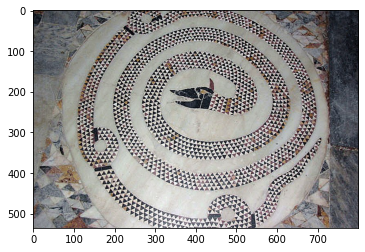

In [70]:
import urllib.request
from PIL import Image
urllib.request.urlretrieve('https://upload.wikimedia.org/wikipedia/commons/5/58/6-13_snake.jpg', '6-13_snake.jpg')
img_pil = Image.open('800px-6-13_snake.jpg')
img = np.array(img_pil)
plt.imshow(img)
plt.show()

 ## Extract the features using convolutional filters extracted from a VGG16

Image input scales:
[(535, 800), (267, 400), (133, 200)]


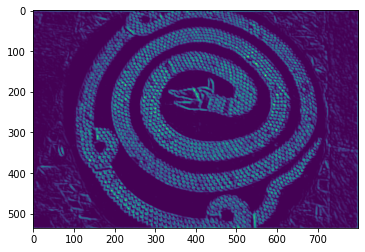

In [73]:
#create the classifier
clf = RandomForestClassifier(random_state=0)

# create feature extractor and apply 
shapes = []
for i in [1,2,4]:
    shapes.append((int(img.shape[0]/i),(int(img.shape[1]/i))))
print("Image input scales:")
print(shapes)
models = init_VGG16_pyramid(shapes)
features = fd_VGG16_pyramid(img,models,shapes)
# plot example filter response
plt.imshow(features[:,:,100])
plt.show()

## Annotate some pixels and train the classifier!
Labels:  
0 : Not annotated (transparent)  
1 : Foreground (yellow)  
2 : Background (red)  

In [90]:
viewer = napari.view_image(img, name="My Image")
viewer.window.add_dock_widget(clf_widget)
prediction_layer = viewer.add_image(np.zeros_like(img[:,:,0]),colormap='PiYG',contrast_limits=(0, 1))
prediction_layer.visible = False
prediction_layer.name = "Classifier prediction"
labels_layer = viewer.add_labels(np.zeros_like(img[:,:,0]).astype(int), seed = 0)
napari.run()

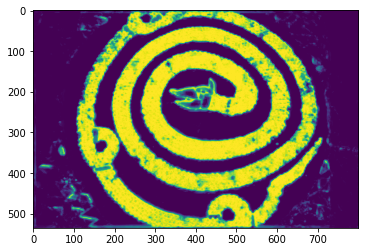

In [65]:
# plot the final prediction image
plt.imshow(prediction_layer.data)

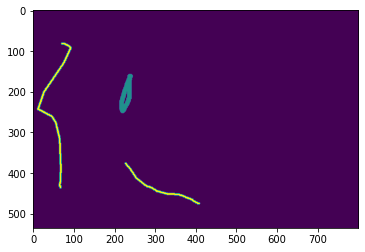

In [91]:
#plot the drawn annotations
plt.imshow(labels_layer.data)

## In depth description of classifier
### Feature extraction using VGG16 transfer learning
VGG16 is an is a convolutional neural network for image recognition proposed by Simonyan and Zisserman. A model trained on the ImageNet Dataset is downloaded trough Keras (TensorFlow backend). Training is disabled and the VGG16 network is cut off before the first Pooling layer. In consequence the output layer preserves the spatial resolution of the input image, resulting in a feature vector of length 64 for each pixel. As the network has been trained on the task of general object detection on ImageNet, the filters in the first layers capture low level features such as edges or textures that can be used for characterising objects such as nuclei. The relatively small filter size (3\*3px) VGG16 introduced (previous state of the art was 11\*11px and 7\*7px), and the discard-
ing of the deeper levels means that only the immediate neighbourhood is taken into account when calculating the features for each pixel. This leads to a noisy prediction, and loss of information of larger scale features. We
found that the noisy prediction and loss of information of larger scale features can be counteracted by inputting
the image at multiple scales, constructing a *featurized image pyramid*.
### Construction of a featurized image pyramid
CNNs using different scales/resolutions of the input image are used in popular segmentation models like UNets, and across different domains (e.g. self driving). Although there exist faster approaches of providing differently scaled data to a neural networks, (e.g.by calculating a *pyramidal feature hierarchy* or by using *Feature Pyramid Networks*, see Lin et al.for an overview), these strategies are not applicable with the transfer learning approach relied on here. Four scalings (1/1, 1/2, 1/4, 1/8) are applied to the input image. The scaled images are then passed separately trough the modified VGG16 model. The outputs are scaled up to match the original spatial  resolution and then concatenated, resulting in 4\*64 = 256 features per pixel. No smaller scales were used as adding them did not improve segmentation results, they should however be considered if working with higher resolution images or different microscope optics (e.g. magnification over 40x).